In [23]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imageio
import os
import scipy
import re
from scipy.ndimage import generate_binary_structure
from skimage.measure import label
from functools import reduce
from moviepy.editor import ImageSequenceClip
from project.utils import reindex_cell_labels

### Making classes for lineage reconstruction

In [6]:
class Clade:
    def __init__(self, label, n_frames):
        self.label = label
        self.cell_track = {}
        self.cell_track_inv = {}
        self.tot_n_cells = 1
        self.initialize_frames(n_frames)
        
    def initialize_frames(self, n_frames):
        for f in range(n_frames):
            self.cell_track[f] = {}
            
    def add_cell(self, frame, cell_label_t, cell_label_tp1):
        print('Adding cell F{0}:C{1} to clade Cla{2}'.format(str(frame), str(cell_label_t), str(self.label)))
        if cell_label_t not in self.cell_track[frame]:
            self.cell_track[frame][cell_label_t] = cell_label_tp1
        else:
            self.cell_track[frame][str(cell_label_t)+'_'] = cell_label_tp1
            #self.cell_track_inv[frame][str(cell_label_tp1)+'_'] = cell_label_t
        self.tot_n_cells+=1
        
class CladeContainer:
    def __init__(self, n_frames):
        self.clades = {}
        self.n_clades_per_frame = {}
        self.n_tot_clades = 0
        self.cells_index = {}
        self.cells_best_score = {}
        self.n_frames = n_frames
        self.initialize_frames(n_frames)
        
    def initialize_frames(self, n_frames):
        for f in range(n_frames):
            self.cells_index[f] = {}
            self.cells_best_score[f] = {}
        
    def look_for_cell(self, frame, cell_label):
    # Check if a cell was already assigned to a Clade
        if cell_label in self.cells_index[frame] :
            return(self.cells_index[frame][cell_label]) # Return clade label
        else:
            return(-1)  # If cells not in any clade
        
    def add_clade(self, clade):
        self.clades[clade.label] = clade
        
    def create_clade(self, clade_lab):
        print('Creating new clade with label : '+str(clade_lab))
        new_clade = Clade(clade_lab, self.n_frames)
        self.add_clade(new_clade)
        #self.n_tot_clades += 1
        
    def gen_new_clade_label(self):
        self.n_tot_clades += 1 
        return(self.n_tot_clades)
    
    def auto_add_cell(self, frame, cell_lab_t, cell_lab_tp1, best_score):
        clade_lab = self.look_for_cell(frame=frame, cell_label=cell_lab_t)
        if clade_lab == (-1) :
            clade_lab = self.gen_new_clade_label()
            self.create_clade(clade_lab)
        if cell_lab_t in self.cells_best_score[frame]:
            if best_score > self.cells_best_score[frame][cell_lab_t]:
                print('SCORE IMPROVEMENT')
                print('Add cell link to EXISTING clade : F{0}:C{1}-F{2}:C{3}'.format(str(frame), str(cell_lab_t), str(frame+1), str(cell_lab_tp1))) 
                self.clades[clade_lab].add_cell(frame_number, cell_label_t=cell_lab_t, cell_label_tp1=cell_lab_tp1)
                self.cells_index[frame][cell_lab_t] = clade_lab
                self.cells_index[frame+1][cell_lab_tp1] = clade_lab
            else:
                print('NO SCORE IMPROVEMENT : IGNORING THIS CELL')
        else:
            print('Add cell link to EXISTING clade : F{0}:C{1}-F{2}:C{3}'.format(str(frame), str(cell_lab_t), str(frame+1), str(cell_lab_tp1)))
            self.clades[clade_lab].add_cell(frame_number, cell_label_t=cell_lab_t, cell_label_tp1=cell_lab_tp1)
            self.cells_index[frame][cell_lab_t] = clade_lab
            self.cells_index[frame+1][cell_lab_tp1] = clade_lab
        
    def auto_add_2_cells(self, frame, cell_lab_1_t, cell_lab_1_tp1, cell_lab_2_t, cell_lab_2_tp1,best_score1,best_score2):
        clade_lab_1 = self.look_for_cell(frame=frame, cell_label=cell_lab_1_t)
        clade_lab_2 = self.look_for_cell(frame=frame, cell_label=cell_lab_2_t)
        if clade_lab_1 == -1 & clade_lab_2 == -1 :
            clade_lab = self.gen_new_clade_label()
            self.create_clade(clade_lab)
        else:
            clade_lab = max(clade_lab_1, clade_lab_2)
            print('Add 2 cells to EXISTING clade {4} : F{0}:C{2}-F{1}:C{3}'.format(str(frame), str(frame+1),
                                                                               str(cell_lab_1_t), 
                                                                               str(cell_lab_1_tp1),
                                                                               str(clade_lab)))
            print('Add 2 cells to EXISTING clade {4} : F{0}:C{2}-F{1}:C{3}'.format(str(frame), str(frame+1),
                                                                               str(cell_lab_2_t), 
                                                                               str(cell_lab_2_tp1),
                                                                               str(clade_lab)))
        if cell_lab_1_t in self.cells_best_score[frame]:
            if best_score1 > self.cells_best_score[frame][cell_lab_1_t]:
                print('SCORE IMPROVEMENT')
                print('Add cell link to EXISTING clade : F{0}:C{1}-F{2}:C{3}'.format(str(frame), str(cell_lab_t), str(frame+1), str(cell_lab_tp1))) 
                self.clades[clade_lab].add_cell(frame_number, cell_label_t=cell_lab_t, cell_label_tp1=cell_lab_tp1)
                self.cells_index[frame][cell_lab_t] = clade_lab
                self.cells_index[frame+1][cell_lab_tp1] = clade_lab
            else:
                print('NO SCORE IMPROVEMENT : IGNORING THIS CELL') 
        else:
            # No other candidate were found : add the cell
            self.clades[clade_lab].add_cell(frame_number, cell_label_t=cell_lab_1_t, cell_label_tp1=cell_lab_1_tp1)
            self.cells_index[frame][cell_lab_1_t] = clade_lab
            self.cells_index[frame+1][cell_lab_1_tp1] = clade_lab
        if cell_lab_2_t in self.cells_best_score[frame]:
            if best_score2 > self.cells_best_score[frame][cell_lab_2_t]:
                print('SCORE IMPROVEMENT')
                print('Add cell link to EXISTING clade : F{0}:C{1}-F{2}:C{3}'.format(str(frame), str(cell_lab_t), str(frame+1), str(cell_lab_tp1))) 
                self.clades[clade_lab].add_cell(frame_number, cell_label_t=cell_lab_t, cell_label_tp1=cell_lab_tp1)
                self.cells_index[frame][cell_lab_t] = clade_lab
                self.cells_index[frame+1][cell_lab_tp1] = clade_lab
            else:
                print('NO SCORE IMPROVEMENT : IGNORING THIS CELL') 
        else:
            self.clades[clade_lab].add_cell(frame_number, cell_label_t=cell_lab_2_t, cell_label_tp1=cell_lab_2_tp1)
            self.cells_index[frame][cell_lab_2_t] = clade_lab
            self.cells_index[frame+1][cell_lab_2_tp1] = clade_lab
        
class ImageSegHandler:
    def __init__(self, track_file_dir, seg_file_dir):
        self.tracks = []
        self.tracks_p = []
        self.f_tracks = []
        self.cell_labels_tracks = []
        self.segs = np.zeros((125,300,300))
        self.labs = np.zeros((125,300,300))
        self.list_files = sorted(os.listdir(track_file_dir))
        self.load_segs_labs(seg_file_dir)
        self.load_track_files(track_file_dir)
        
    def load_segs_labs(self, seg_dir):
        list_files = sorted(os.listdir(seg_dir))
        for i, file in enumerate(list_files):
            self.segs[i,:,:] = cv2.imread(seg_dir + file)[:,:,0]
            temp_labs = label(self.segs[i,:,:].copy())
            # Filter cells with less than 20 pixels 
            #cell_labs = np.unique(imgseg_obj.labs[1], return_counts=True)[0]
            #lab_count = np.unique(imgseg_obj.labs[1], return_counts=True)[1]
            #for c, cell in enumerate(cell_labs):
            #    if lab_count[c] < 20:
            #        temp_labs[temp_labs == cell] = 0
            self.labs[i,:,:] = temp_labs
            
    def load_track_files(self, track_dir):
        # Predictions are written in the form of many png files that needs to be compiled in a tif
        list_track = [] # we use a list as images have different shapes
        list_cell_labels, list_frames = [], []
        for f, file in enumerate(self.list_files):
            #I = np.array(cv2.imread(track_dir + file))
            #I_gray = (I)# + I[:,:,1] + I[:,:,2] )/ 3
            #self.tracks.append(I_gray)
            #self.tracks_p.append(np.array(I_gray / 255).astype(float))
            list_cell_labels.append(int(file[-7:-4]))
            list_frames.append(int(file[-18:-14]))
        # Get all frame and labels 
        self.cell_labels_tracks = list_cell_labels
        self.f_tracks = list_frames

Hereafter we iterate over all prediction images made by delta, find back probabilities associated with each cell and define the link between cells at time t and time t+1 

In [11]:
track_file_dir = 'data/predictions/tracking/small_window_pred/'
seg_file_dir = 'data/predictions/tracking/small_window_seg/' # we need the associated segmentation in same region !

# Contruct the object ImageSegHandler that contains all images, segmentation and labelling 
imgseg_obj = ImageSegHandler(track_file_dir, seg_file_dir)
# Initialize CladeContainer object which contains ImageSegHandler object and will contains all cell lineage infered
clade_con = CladeContainer(len(imgseg_obj.segs))

In [12]:
# How many tracking image do we have ? 
len(imgseg_obj.list_files)

2630

In [13]:
# We iterate over tracked files 
for i, file in enumerate(imgseg_obj.list_files):
    cell_number = imgseg_obj.cell_labels_tracks[i]
    frame_number = imgseg_obj.f_tracks[i]
    I = np.array(cv2.imread(track_file_dir + file))
    p_map = np.array(I / 255).astype(float)
    #p_map = imgseg_obj.tracks_p[i].copy()

    seg_tm1 = imgseg_obj.segs[frame_number].copy()
    seg_t   = imgseg_obj.segs[frame_number+1].copy()
    lab_tm1 = imgseg_obj.labs[frame_number].copy()
    lab_t   = imgseg_obj.labs[frame_number+1].copy()
    lab2work = lab_tm1.copy()

    lab2work[lab2work != cell_number] = 0
    lab2work[lab2work == cell_number] = 1

    if np.sum(lab2work == 1)<2:
        continue
        
    x_mean = int(np.where(lab2work == 1)[0].mean())
    y_mean = int(np.where(lab2work == 1)[1].mean())
    
    shape_lab = lab2work.shape

    # This are the coordinate on the main image segmentation 
    x_start = int(max(x_mean - (256/2), 0))
    x_end = int(min(x_mean + (256/2), 300))
    y_start = int(max(y_mean - (256/2), 0))
    y_end = int(min(y_mean + (256/2), 300))
    # Here after the coordinate we calculate for the (256,256) subset we take to fit the prediction images
    x_reform_start = int(abs(min(x_mean - (256/2), 0)))
    y_reform_start = int(abs(min(y_mean - (256/2), 0)))
    x_reform_end = int(abs(min(x_mean + (256/2), 256)))
    y_reform_end = int(abs(min(y_mean + (256/2), 256)))
    x_shift, y_shift = 0, 0
    if x_mean + (256/2) > 300: 
        x_shift = int(300 - (x_mean + (256/2)))
    if y_mean + (256/2) > 300: 
        y_shift = int(300 - (y_mean + (256/2)))
    x_reform_end = int(abs(min(x_mean + (256/2), 256))) + x_shift + x_reform_start
    y_reform_end = int(abs(min(y_mean + (256/2), 256))) + y_shift + y_reform_start

    # This is the (256,256) segmentation image that matches the prediction (256,256) image
    centered_seg = np.zeros((256,256))
    centered_seg[x_reform_start:x_reform_end, y_reform_start:y_reform_end] = lab_t[x_start:x_end,y_start:y_end].copy()

    # We can get unique labels and connect probabilities of prediction with cell labels 
    cell_labs = np.unique(centered_seg)
    track_score = [] ; track_mean = []
    for cell in cell_labs:
        track_score.append(p_map[centered_seg==cell])
        track_mean.append(np.mean(p_map[centered_seg==cell]))
    
    # How many significant cell tracking were obtained ? 
    n_signif = np.sum(np.array(track_mean) > 0.5)
    
    # Cell tracked one cell in next frame
    if n_signif == 1 :
        idx = np.argsort(-np.array(track_mean))[0]
        best_score = track_mean[idx]
        clabs = int(cell_labs[idx])
        clade_con.auto_add_cell(frame_number, cell_number, clabs, best_score)
    elif n_signif > 1 : # Cell tracked 2 cells in next frame : potential division ! 
        print('DIVISION')
        idx_1 = np.argsort(-np.array(track_mean))[0]
        idx_2 = np.argsort(-np.array(track_mean))[1]
        best_score1 = track_mean[idx_1]
        best_score2 = track_mean[idx_2]
        clabs1 = int(cell_labs[idx_1])
        clabs2 = int(cell_labs[idx_2])
        clade_con.auto_add_2_cells(frame_number, cell_number, clabs1, cell_number, clabs2,best_score1,best_score2)

Creating new clade with label : 1
Add cell link to EXISTING clade : F1:C1-F2:C1
Adding cell F1:C1 to clade Cla1
Creating new clade with label : 2
Add cell link to EXISTING clade : F1:C6-F2:C5
Adding cell F1:C6 to clade Cla2
Creating new clade with label : 3
Add cell link to EXISTING clade : F1:C11-F2:C9
Adding cell F1:C11 to clade Cla3
Creating new clade with label : 4
Add cell link to EXISTING clade : F1:C14-F2:C13
Adding cell F1:C14 to clade Cla4
Creating new clade with label : 5
Add cell link to EXISTING clade : F1:C15-F2:C14
Adding cell F1:C15 to clade Cla5
DIVISION
Creating new clade with label : 6
Adding cell F1:C17 to clade Cla6
Adding cell F1:C17 to clade Cla6
Add cell link to EXISTING clade : F2:C1-F3:C1
Adding cell F2:C1 to clade Cla1
DIVISION
Creating new clade with label : 7
Adding cell F2:C3 to clade Cla7
Adding cell F2:C3 to clade Cla7
DIVISION
Creating new clade with label : 8
Adding cell F2:C4 to clade Cla8
Adding cell F2:C4 to clade Cla8
Creating new clade with label :

DIVISION
Add 2 cells to EXISTING clade 18 : F8:C13-F9:C12
Add 2 cells to EXISTING clade 18 : F8:C13-F9:C14
Adding cell F8:C13 to clade Cla18
Adding cell F8:C13 to clade Cla18
DIVISION
Add 2 cells to EXISTING clade 27 : F8:C14-F9:C14
Add 2 cells to EXISTING clade 27 : F8:C14-F9:C12
Adding cell F8:C14 to clade Cla27
Adding cell F8:C14 to clade Cla27
DIVISION
Add 2 cells to EXISTING clade 28 : F8:C15-F9:C16
Add 2 cells to EXISTING clade 28 : F8:C15-F9:C13
Adding cell F8:C15 to clade Cla28
Adding cell F8:C15 to clade Cla28
Add cell link to EXISTING clade : F9:C1-F10:C1
Adding cell F9:C1 to clade Cla1
DIVISION
Add 2 cells to EXISTING clade 19 : F9:C2-F10:C2
Add 2 cells to EXISTING clade 19 : F9:C2-F10:C3
Adding cell F9:C2 to clade Cla19
Adding cell F9:C2 to clade Cla19
DIVISION
Add 2 cells to EXISTING clade 8 : F9:C3-F10:C3
Add 2 cells to EXISTING clade 8 : F9:C3-F10:C2
Adding cell F9:C3 to clade Cla8
Adding cell F9:C3 to clade Cla8
DIVISION
Add 2 cells to EXISTING clade 19 : F9:C4-F10:C4
A

DIVISION
Add 2 cells to EXISTING clade 35 : F15:C5-F16:C4
Add 2 cells to EXISTING clade 35 : F15:C5-F16:C6
Adding cell F15:C5 to clade Cla35
Adding cell F15:C5 to clade Cla35
Creating new clade with label : 42
Add cell link to EXISTING clade : F15:C6-F16:C5
Adding cell F15:C6 to clade Cla42
DIVISION
Creating new clade with label : 43
Adding cell F15:C7 to clade Cla43
Adding cell F15:C7 to clade Cla43
DIVISION
Creating new clade with label : 44
Adding cell F15:C8 to clade Cla44
Adding cell F15:C8 to clade Cla44
Creating new clade with label : 45
Add cell link to EXISTING clade : F15:C12-F16:C11
Adding cell F15:C12 to clade Cla45
Creating new clade with label : 46
Add cell link to EXISTING clade : F15:C13-F16:C12
Adding cell F15:C13 to clade Cla46
Add cell link to EXISTING clade : F15:C14-F16:C13
Adding cell F15:C14 to clade Cla29
DIVISION
Add 2 cells to EXISTING clade 8 : F16:C1-F17:C1
Add 2 cells to EXISTING clade 8 : F16:C1-F17:C3
Adding cell F16:C1 to clade Cla8
Adding cell F16:C1 to

Add cell link to EXISTING clade : F22:C12-F23:C11
Adding cell F22:C12 to clade Cla59
Add cell link to EXISTING clade : F22:C16-F23:C15
Adding cell F22:C16 to clade Cla29
DIVISION
Add 2 cells to EXISTING clade 8 : F23:C1-F24:C2
Add 2 cells to EXISTING clade 8 : F23:C1-F24:C3
Adding cell F23:C1 to clade Cla8
Adding cell F23:C1 to clade Cla8
DIVISION
Add 2 cells to EXISTING clade 8 : F23:C2-F24:C3
Add 2 cells to EXISTING clade 8 : F23:C2-F24:C9
Adding cell F23:C2 to clade Cla8
Adding cell F23:C2 to clade Cla8
DIVISION
Creating new clade with label : 62
Adding cell F23:C3 to clade Cla62
Adding cell F23:C3 to clade Cla62
DIVISION
Creating new clade with label : 63
Adding cell F23:C4 to clade Cla63
Adding cell F23:C4 to clade Cla63
DIVISION
Add 2 cells to EXISTING clade 47 : F23:C5-F24:C6
Add 2 cells to EXISTING clade 47 : F23:C5-F24:C9
Adding cell F23:C5 to clade Cla47
Adding cell F23:C5 to clade Cla47
DIVISION
Add 2 cells to EXISTING clade 42 : F23:C6-F24:C8
Add 2 cells to EXISTING clade 4

DIVISION
Add 2 cells to EXISTING clade 72 : F29:C10-F30:C8
Add 2 cells to EXISTING clade 72 : F29:C10-F30:C9
Adding cell F29:C10 to clade Cla72
Adding cell F29:C10 to clade Cla72
DIVISION
Add 2 cells to EXISTING clade 72 : F29:C11-F30:C9
Add 2 cells to EXISTING clade 72 : F29:C11-F30:C8
Adding cell F29:C11 to clade Cla72
Adding cell F29:C11 to clade Cla72
DIVISION
Add 2 cells to EXISTING clade 77 : F29:C12-F30:C10
Add 2 cells to EXISTING clade 77 : F29:C12-F30:C11
Adding cell F29:C12 to clade Cla77
Adding cell F29:C12 to clade Cla77
Add cell link to EXISTING clade : F29:C14-F30:C12
Adding cell F29:C14 to clade Cla79
Add cell link to EXISTING clade : F30:C2-F31:C2
Adding cell F30:C2 to clade Cla68
Add cell link to EXISTING clade : F30:C5-F31:C6
Adding cell F30:C5 to clade Cla76
Add cell link to EXISTING clade : F30:C6-F31:C7
Adding cell F30:C6 to clade Cla70
Add cell link to EXISTING clade : F30:C9-F31:C11
Adding cell F30:C9 to clade Cla72
Add cell link to EXISTING clade : F30:C10-F31:C

DIVISION
Add 2 cells to EXISTING clade 95 : F38:C6-F39:C7
Add 2 cells to EXISTING clade 95 : F38:C6-F39:C9
Adding cell F38:C6 to clade Cla95
Adding cell F38:C6 to clade Cla95
DIVISION
Add 2 cells to EXISTING clade 94 : F38:C7-F39:C6
Add 2 cells to EXISTING clade 94 : F38:C7-F39:C12
Adding cell F38:C7 to clade Cla94
Adding cell F38:C7 to clade Cla94
DIVISION
Creating new clade with label : 98
Adding cell F38:C8 to clade Cla98
Adding cell F38:C8 to clade Cla98
DIVISION
Add 2 cells to EXISTING clade 88 : F38:C9-F39:C9
Add 2 cells to EXISTING clade 88 : F38:C9-F39:C8
Adding cell F38:C9 to clade Cla88
Adding cell F38:C9 to clade Cla88
DIVISION
Add 2 cells to EXISTING clade 96 : F38:C10-F39:C10
Add 2 cells to EXISTING clade 96 : F38:C10-F39:C11
Adding cell F38:C10 to clade Cla96
Adding cell F38:C10 to clade Cla96
DIVISION
Creating new clade with label : 99
Adding cell F38:C11 to clade Cla99
Adding cell F38:C11 to clade Cla99
DIVISION
Creating new clade with label : 100
Adding cell F38:C12 to

DIVISION
Add 2 cells to EXISTING clade 118 : F46:C1-F47:C1
Add 2 cells to EXISTING clade 118 : F46:C1-F47:C3
Adding cell F46:C1 to clade Cla118
Adding cell F46:C1 to clade Cla118
DIVISION
Add 2 cells to EXISTING clade 119 : F46:C2-F47:C2
Add 2 cells to EXISTING clade 119 : F46:C2-F47:C6
Adding cell F46:C2 to clade Cla119
Adding cell F46:C2 to clade Cla119
DIVISION
Add 2 cells to EXISTING clade 121 : F46:C3-F47:C3
Add 2 cells to EXISTING clade 121 : F46:C3-F47:C6
Adding cell F46:C3 to clade Cla121
Adding cell F46:C3 to clade Cla121
DIVISION
Add 2 cells to EXISTING clade 120 : F46:C4-F47:C4
Add 2 cells to EXISTING clade 120 : F46:C4-F47:C3
Adding cell F46:C4 to clade Cla120
Adding cell F46:C4 to clade Cla120
DIVISION
Add 2 cells to EXISTING clade 104 : F46:C5-F47:C5
Add 2 cells to EXISTING clade 104 : F46:C5-F47:C3
Adding cell F46:C5 to clade Cla104
Adding cell F46:C5 to clade Cla104
DIVISION
Add 2 cells to EXISTING clade 121 : F46:C6-F47:C6
Add 2 cells to EXISTING clade 121 : F46:C6-F47

DIVISION
Add 2 cells to EXISTING clade 122 : F49:C8-F50:C8
Add 2 cells to EXISTING clade 122 : F49:C8-F50:C9
Adding cell F49:C8 to clade Cla122
Adding cell F49:C8 to clade Cla122
Add cell link to EXISTING clade : F49:C17-F50:C15
Adding cell F49:C17 to clade Cla116
Add cell link to EXISTING clade : F49:C18-F50:C16
Adding cell F49:C18 to clade Cla127
Creating new clade with label : 128
Add cell link to EXISTING clade : F49:C19-F50:C17
Adding cell F49:C19 to clade Cla128
DIVISION
Add 2 cells to EXISTING clade 118 : F50:C1-F51:C1
Add 2 cells to EXISTING clade 118 : F50:C1-F51:C3
Adding cell F50:C1 to clade Cla118
Adding cell F50:C1 to clade Cla118
DIVISION
Add 2 cells to EXISTING clade 119 : F50:C2-F51:C2
Add 2 cells to EXISTING clade 119 : F50:C2-F51:C4
Adding cell F50:C2 to clade Cla119
Adding cell F50:C2 to clade Cla119
DIVISION
Add 2 cells to EXISTING clade 118 : F50:C3-F51:C3
Add 2 cells to EXISTING clade 118 : F50:C3-F51:C4
Adding cell F50:C3 to clade Cla118
Adding cell F50:C3 to cla

Add cell link to EXISTING clade : F56:C2-F57:C2
Adding cell F56:C2 to clade Cla119
DIVISION
Creating new clade with label : 146
Adding cell F56:C3 to clade Cla146
Adding cell F56:C3 to clade Cla146
Add cell link to EXISTING clade : F56:C4-F57:C4
Adding cell F56:C4 to clade Cla136
DIVISION
Add 2 cells to EXISTING clade 118 : F56:C5-F57:C5
Add 2 cells to EXISTING clade 118 : F56:C5-F57:C6
Adding cell F56:C5 to clade Cla118
Adding cell F56:C5 to clade Cla118
DIVISION
Creating new clade with label : 147
Adding cell F56:C6 to clade Cla147
Adding cell F56:C6 to clade Cla147
DIVISION
Add 2 cells to EXISTING clade 104 : F56:C7-F57:C7
Add 2 cells to EXISTING clade 104 : F56:C7-F57:C5
Adding cell F56:C7 to clade Cla104
Adding cell F56:C7 to clade Cla104
DIVISION
Add 2 cells to EXISTING clade 140 : F56:C8-F57:C8
Add 2 cells to EXISTING clade 140 : F56:C8-F57:C10
Adding cell F56:C8 to clade Cla140
Adding cell F56:C8 to clade Cla140
DIVISION
Add 2 cells to EXISTING clade 141 : F56:C9-F57:C9
Add 2 c

DIVISION
Creating new clade with label : 155
Adding cell F60:C13 to clade Cla155
Adding cell F60:C13 to clade Cla155
DIVISION
Creating new clade with label : 156
Adding cell F60:C14 to clade Cla156
Adding cell F60:C14 to clade Cla156
DIVISION
Creating new clade with label : 157
Adding cell F60:C15 to clade Cla157
Adding cell F60:C15 to clade Cla157
DIVISION
Creating new clade with label : 158
Adding cell F60:C16 to clade Cla158
Adding cell F60:C16 to clade Cla158
DIVISION
Creating new clade with label : 159
Adding cell F60:C17 to clade Cla159
Adding cell F60:C17 to clade Cla159
Creating new clade with label : 160
Add cell link to EXISTING clade : F60:C18-F61:C17
Adding cell F60:C18 to clade Cla160
DIVISION
Add 2 cells to EXISTING clade 119 : F61:C1-F62:C1
Add 2 cells to EXISTING clade 119 : F61:C1-F62:C3
Adding cell F61:C1 to clade Cla119
Adding cell F61:C1 to clade Cla119
Add cell link to EXISTING clade : F61:C2-F62:C2
Adding cell F61:C2 to clade Cla118
DIVISION
Add 2 cells to EXISTIN

Add cell link to EXISTING clade : F67:C13-F68:C12
Adding cell F67:C13 to clade Cla151
DIVISION
Add 2 cells to EXISTING clade 151 : F67:C14-F68:C13
Add 2 cells to EXISTING clade 151 : F67:C14-F68:C12
Adding cell F67:C14 to clade Cla151
Adding cell F67:C14 to clade Cla151
DIVISION
Add 2 cells to EXISTING clade 174 : F67:C15-F68:C14
Add 2 cells to EXISTING clade 174 : F67:C15-F68:C9
Adding cell F67:C15 to clade Cla174
Adding cell F67:C15 to clade Cla174
DIVISION
Add 2 cells to EXISTING clade 147 : F68:C1-F69:C1
Add 2 cells to EXISTING clade 147 : F68:C1-F69:C2
Adding cell F68:C1 to clade Cla147
Adding cell F68:C1 to clade Cla147
Add cell link to EXISTING clade : F68:C2-F69:C8
Adding cell F68:C2 to clade Cla118
DIVISION
Add 2 cells to EXISTING clade 147 : F68:C3-F69:C2
Add 2 cells to EXISTING clade 147 : F68:C3-F69:C1
Adding cell F68:C3 to clade Cla147
Adding cell F68:C3 to clade Cla147
Add cell link to EXISTING clade : F68:C4-F69:C3
Adding cell F68:C4 to clade Cla170
DIVISION
Add 2 cells 

Add cell link to EXISTING clade : F75:C7-F76:C7
Adding cell F75:C7 to clade Cla194
Add cell link to EXISTING clade : F75:C8-F76:C9
Adding cell F75:C8 to clade Cla195
Add cell link to EXISTING clade : F75:C11-F76:C11
Adding cell F75:C11 to clade Cla190
Add cell link to EXISTING clade : F75:C12-F76:C12
Adding cell F75:C12 to clade Cla198
Add cell link to EXISTING clade : F75:C15-F76:C15
Adding cell F75:C15 to clade Cla183
Add cell link to EXISTING clade : F75:C16-F76:C16
Adding cell F75:C16 to clade Cla190
DIVISION
Add 2 cells to EXISTING clade 147 : F76:C1-F77:C1
Add 2 cells to EXISTING clade 147 : F76:C1-F77:C5
Adding cell F76:C1 to clade Cla147
Adding cell F76:C1 to clade Cla147
Add cell link to EXISTING clade : F76:C5-F77:C6
Adding cell F76:C5 to clade Cla195
Add cell link to EXISTING clade : F76:C7-F77:C9
Adding cell F76:C7 to clade Cla194
Creating new clade with label : 201
Add cell link to EXISTING clade : F76:C8-F77:C10
Adding cell F76:C8 to clade Cla201
Creating new clade with l

Add cell link to EXISTING clade : F81:C16-F82:C16
Adding cell F81:C16 to clade Cla217
DIVISION
Creating new clade with label : 219
Adding cell F81:C17 to clade Cla219
Adding cell F81:C17 to clade Cla219
DIVISION
Add 2 cells to EXISTING clade 195 : F82:C2-F83:C1
Add 2 cells to EXISTING clade 195 : F82:C2-F83:C8
Adding cell F82:C2 to clade Cla195
Adding cell F82:C2 to clade Cla195
DIVISION
Add 2 cells to EXISTING clade 202 : F82:C3-F83:C5
Add 2 cells to EXISTING clade 202 : F82:C3-F83:C2
Adding cell F82:C3 to clade Cla202
Adding cell F82:C3 to clade Cla202
DIVISION
Add 2 cells to EXISTING clade 202 : F82:C4-F83:C3
Add 2 cells to EXISTING clade 202 : F82:C4-F83:C14
Adding cell F82:C4 to clade Cla202
Adding cell F82:C4 to clade Cla202
DIVISION
Add 2 cells to EXISTING clade 214 : F82:C5-F83:C4
Add 2 cells to EXISTING clade 214 : F82:C5-F83:C14
Adding cell F82:C5 to clade Cla214
Adding cell F82:C5 to clade Cla214
DIVISION
Add 2 cells to EXISTING clade 212 : F82:C6-F83:C6
Add 2 cells to EXIST

DIVISION
Add 2 cells to EXISTING clade 219 : F84:C17-F85:C17
Add 2 cells to EXISTING clade 219 : F84:C17-F85:C19
Adding cell F84:C17 to clade Cla219
Adding cell F84:C17 to clade Cla219
DIVISION
Add 2 cells to EXISTING clade 223 : F84:C18-F85:C18
Add 2 cells to EXISTING clade 223 : F84:C18-F85:C13
Adding cell F84:C18 to clade Cla223
Adding cell F84:C18 to clade Cla223
DIVISION
Add 2 cells to EXISTING clade 219 : F84:C19-F85:C19
Add 2 cells to EXISTING clade 219 : F84:C19-F85:C10
Adding cell F84:C19 to clade Cla219
Adding cell F84:C19 to clade Cla219
DIVISION
Add 2 cells to EXISTING clade 202 : F85:C1-F86:C1
Add 2 cells to EXISTING clade 202 : F85:C1-F86:C2
Adding cell F85:C1 to clade Cla202
Adding cell F85:C1 to clade Cla202
DIVISION
Add 2 cells to EXISTING clade 202 : F85:C2-F86:C2
Add 2 cells to EXISTING clade 202 : F85:C2-F86:C1
Adding cell F85:C2 to clade Cla202
Adding cell F85:C2 to clade Cla202
DIVISION
Add 2 cells to EXISTING clade 195 : F85:C3-F86:C3
Add 2 cells to EXISTING clad

DIVISION
Creating new clade with label : 239
Adding cell F89:C13 to clade Cla239
Adding cell F89:C13 to clade Cla239
DIVISION
Add 2 cells to EXISTING clade 235 : F89:C14-F90:C16
Add 2 cells to EXISTING clade 235 : F89:C14-F90:C13
Adding cell F89:C14 to clade Cla235
Adding cell F89:C14 to clade Cla235
DIVISION
Add 2 cells to EXISTING clade 226 : F89:C15-F90:C17
Add 2 cells to EXISTING clade 226 : F89:C15-F90:C19
Adding cell F89:C15 to clade Cla226
Adding cell F89:C15 to clade Cla226
DIVISION
Add 2 cells to EXISTING clade 228 : F89:C16-F90:C17
Add 2 cells to EXISTING clade 228 : F89:C16-F90:C19
Adding cell F89:C16 to clade Cla228
Adding cell F89:C16 to clade Cla228
DIVISION
Add 2 cells to EXISTING clade 237 : F89:C17-F90:C18
Add 2 cells to EXISTING clade 237 : F89:C17-F90:C21
Adding cell F89:C17 to clade Cla237
Adding cell F89:C17 to clade Cla237
DIVISION
Add 2 cells to EXISTING clade 228 : F89:C18-F90:C19
Add 2 cells to EXISTING clade 228 : F89:C18-F90:C17
Adding cell F89:C18 to clade C

DIVISION
Add 2 cells to EXISTING clade 202 : F93:C1-F94:C1
Add 2 cells to EXISTING clade 202 : F93:C1-F94:C10
Adding cell F93:C1 to clade Cla202
Adding cell F93:C1 to clade Cla202
DIVISION
Add 2 cells to EXISTING clade 202 : F93:C2-F94:C2
Add 2 cells to EXISTING clade 202 : F93:C2-F94:C4
Adding cell F93:C2 to clade Cla202
Adding cell F93:C2 to clade Cla202
DIVISION
Add 2 cells to EXISTING clade 195 : F93:C3-F94:C3
Add 2 cells to EXISTING clade 195 : F93:C3-F94:C5
Adding cell F93:C3 to clade Cla195
Adding cell F93:C3 to clade Cla195
DIVISION
Add 2 cells to EXISTING clade 234 : F93:C5-F94:C4
Add 2 cells to EXISTING clade 234 : F93:C5-F94:C6
Adding cell F93:C5 to clade Cla234
Adding cell F93:C5 to clade Cla234
Add cell link to EXISTING clade : F93:C6-F94:C13
Adding cell F93:C6 to clade Cla245
DIVISION
Add 2 cells to EXISTING clade 195 : F93:C7-F94:C5
Add 2 cells to EXISTING clade 195 : F93:C7-F94:C18
Adding cell F93:C7 to clade Cla195
Adding cell F93:C7 to clade Cla195
DIVISION
Add 2 cell

Creating new clade with label : 252
Add cell link to EXISTING clade : F95:C21-F96:C25
Adding cell F95:C21 to clade Cla252
Add cell link to EXISTING clade : F95:C22-F96:C24
Adding cell F95:C22 to clade Cla238
DIVISION
Add 2 cells to EXISTING clade 202 : F96:C1-F97:C1
Add 2 cells to EXISTING clade 202 : F96:C1-F97:C9
Adding cell F96:C1 to clade Cla202
Adding cell F96:C1 to clade Cla202
DIVISION
Add 2 cells to EXISTING clade 202 : F96:C2-F97:C2
Add 2 cells to EXISTING clade 202 : F96:C2-F97:C9
Adding cell F96:C2 to clade Cla202
Adding cell F96:C2 to clade Cla202
DIVISION
Add 2 cells to EXISTING clade 195 : F96:C3-F97:C3
Add 2 cells to EXISTING clade 195 : F96:C3-F97:C6
Adding cell F96:C3 to clade Cla195
Adding cell F96:C3 to clade Cla195
DIVISION
Add 2 cells to EXISTING clade 234 : F96:C4-F97:C4
Add 2 cells to EXISTING clade 234 : F96:C4-F97:C7
Adding cell F96:C4 to clade Cla234
Adding cell F96:C4 to clade Cla234
DIVISION
Add 2 cells to EXISTING clade 242 : F96:C5-F97:C5
Add 2 cells to EX

Add cell link to EXISTING clade : F99:C15-F100:C18
Adding cell F99:C15 to clade Cla195
Creating new clade with label : 261
Add cell link to EXISTING clade : F99:C22-F100:C23
Adding cell F99:C22 to clade Cla261
Creating new clade with label : 262
Add cell link to EXISTING clade : F99:C27-F100:C27
Adding cell F99:C27 to clade Cla262
DIVISION
Add 2 cells to EXISTING clade 238 : F99:C29-F100:C30
Add 2 cells to EXISTING clade 238 : F99:C29-F100:C29
Adding cell F99:C29 to clade Cla238
Adding cell F99:C29 to clade Cla238
Add cell link to EXISTING clade : F100:C1-F101:C1
Adding cell F100:C1 to clade Cla202
DIVISION
Creating new clade with label : 263
Adding cell F100:C2 to clade Cla263
Adding cell F100:C2 to clade Cla263
Add cell link to EXISTING clade : F100:C9-F101:C9
Adding cell F100:C9 to clade Cla242
DIVISION
Add 2 cells to EXISTING clade 242 : F100:C11-F101:C9
Add 2 cells to EXISTING clade 242 : F100:C11-F101:C12
Adding cell F100:C11 to clade Cla242
Adding cell F100:C11 to clade Cla242
C

Add cell link to EXISTING clade : F103:C17-F104:C15
Adding cell F103:C17 to clade Cla264
DIVISION
Add 2 cells to EXISTING clade 273 : F103:C18-F104:C16
Add 2 cells to EXISTING clade 273 : F103:C18-F104:C18
Adding cell F103:C18 to clade Cla273
Adding cell F103:C18 to clade Cla273
DIVISION
Creating new clade with label : 291
Adding cell F103:C19 to clade Cla291
Adding cell F103:C19 to clade Cla291
Add cell link to EXISTING clade : F103:C21-F104:C18
Adding cell F103:C21 to clade Cla289
Add cell link to EXISTING clade : F103:C24-F104:C22
Adding cell F103:C24 to clade Cla274
Creating new clade with label : 292
Add cell link to EXISTING clade : F103:C28-F104:C26
Adding cell F103:C28 to clade Cla292
Creating new clade with label : 293
Add cell link to EXISTING clade : F103:C29-F104:C27
Adding cell F103:C29 to clade Cla293
DIVISION
Add 2 cells to EXISTING clade 287 : F104:C1-F105:C1
Add 2 cells to EXISTING clade 287 : F104:C1-F105:C7
Adding cell F104:C1 to clade Cla287
Adding cell F104:C1 to c

Creating new clade with label : 322
Add cell link to EXISTING clade : F107:C30-F108:C30
Adding cell F107:C30 to clade Cla322
Add cell link to EXISTING clade : F108:C1-F109:C1
Adding cell F108:C1 to clade Cla295
DIVISION
Add 2 cells to EXISTING clade 280 : F108:C2-F109:C2
Add 2 cells to EXISTING clade 280 : F108:C2-F109:C1
Adding cell F108:C2 to clade Cla280
Adding cell F108:C2 to clade Cla280
Creating new clade with label : 323
Add cell link to EXISTING clade : F108:C3-F109:C3
Adding cell F108:C3 to clade Cla323
DIVISION
Add 2 cells to EXISTING clade 310 : F108:C4-F109:C4
Add 2 cells to EXISTING clade 310 : F108:C4-F109:C7
Adding cell F108:C4 to clade Cla310
Adding cell F108:C4 to clade Cla310
DIVISION
Add 2 cells to EXISTING clade 303 : F108:C6-F109:C5
Add 2 cells to EXISTING clade 303 : F108:C6-F109:C6
Adding cell F108:C6 to clade Cla303
Adding cell F108:C6 to clade Cla303
DIVISION
Add 2 cells to EXISTING clade 303 : F108:C7-F109:C6
Add 2 cells to EXISTING clade 303 : F108:C7-F109:C5

Add cell link to EXISTING clade : F110:C16-F111:C16
Adding cell F110:C16 to clade Cla325
Add cell link to EXISTING clade : F110:C18-F111:C17
Adding cell F110:C18 to clade Cla318
Add cell link to EXISTING clade : F110:C21-F111:C21
Adding cell F110:C21 to clade Cla319
Add cell link to EXISTING clade : F110:C26-F111:C27
Adding cell F110:C26 to clade Cla331
Add cell link to EXISTING clade : F110:C31-F111:C32
Adding cell F110:C31 to clade Cla321
DIVISION
Add 2 cells to EXISTING clade 280 : F111:C1-F112:C1
Add 2 cells to EXISTING clade 280 : F111:C1-F112:C4
Adding cell F111:C1 to clade Cla280
Adding cell F111:C1 to clade Cla280
DIVISION
Add 2 cells to EXISTING clade 280 : F111:C2-F112:C2
Add 2 cells to EXISTING clade 280 : F111:C2-F112:C8
Adding cell F111:C2 to clade Cla280
Adding cell F111:C2 to clade Cla280
Add cell link to EXISTING clade : F111:C3-F112:C3
Adding cell F111:C3 to clade Cla323
DIVISION
Add 2 cells to EXISTING clade 310 : F111:C4-F112:C4
Add 2 cells to EXISTING clade 310 : F1

Add cell link to EXISTING clade : F115:C11-F116:C12
Adding cell F115:C11 to clade Cla340
Add cell link to EXISTING clade : F115:C12-F116:C13
Adding cell F115:C12 to clade Cla280
Add cell link to EXISTING clade : F115:C15-F116:C16
Adding cell F115:C15 to clade Cla360
Add cell link to EXISTING clade : F115:C17-F116:C19
Adding cell F115:C17 to clade Cla362
Add cell link to EXISTING clade : F115:C19-F116:C20
Adding cell F115:C19 to clade Cla352
Add cell link to EXISTING clade : F115:C24-F116:C25
Adding cell F115:C24 to clade Cla365
Add cell link to EXISTING clade : F115:C27-F116:C28
Adding cell F115:C27 to clade Cla347
DIVISION
Add 2 cells to EXISTING clade 280 : F116:C1-F117:C1
Add 2 cells to EXISTING clade 280 : F116:C1-F117:C3
Adding cell F116:C1 to clade Cla280
Adding cell F116:C1 to clade Cla280
DIVISION
Add 2 cells to EXISTING clade 280 : F116:C2-F117:C2
Add 2 cells to EXISTING clade 280 : F116:C2-F117:C3
Adding cell F116:C2 to clade Cla280
Adding cell F116:C2 to clade Cla280
DIVISIO

Add cell link to EXISTING clade : F119:C15-F120:C14
Adding cell F119:C15 to clade Cla340
Add cell link to EXISTING clade : F119:C16-F120:C15
Adding cell F119:C16 to clade Cla280
Add cell link to EXISTING clade : F119:C18-F120:C17
Adding cell F119:C18 to clade Cla391
Add cell link to EXISTING clade : F119:C23-F120:C23
Adding cell F119:C23 to clade Cla391
Add cell link to EXISTING clade : F119:C24-F120:C25
Adding cell F119:C24 to clade Cla393
Add cell link to EXISTING clade : F119:C26-F120:C27
Adding cell F119:C26 to clade Cla394
Add cell link to EXISTING clade : F119:C29-F120:C32
Adding cell F119:C29 to clade Cla397
Creating new clade with label : 399
Add cell link to EXISTING clade : F119:C30-F120:C33
Adding cell F119:C30 to clade Cla399
Add cell link to EXISTING clade : F119:C31-F120:C35
Adding cell F119:C31 to clade Cla365
Add cell link to EXISTING clade : F119:C32-F120:C34
Adding cell F119:C32 to clade Cla396
DIVISION
Add 2 cells to EXISTING clade 398 : F120:C1-F121:C1
Add 2 cells t

Add cell link to EXISTING clade : F122:C16-F123:C13
Adding cell F122:C16 to clade Cla280
DIVISION
Add 2 cells to EXISTING clade 340 : F122:C17-F123:C14
Add 2 cells to EXISTING clade 340 : F122:C17-F123:C16
Adding cell F122:C17 to clade Cla340
Adding cell F122:C17 to clade Cla340
DIVISION
Add 2 cells to EXISTING clade 414 : F122:C18-F123:C15
Add 2 cells to EXISTING clade 414 : F122:C18-F123:C19
Adding cell F122:C18 to clade Cla414
Adding cell F122:C18 to clade Cla414
DIVISION
Add 2 cells to EXISTING clade 413 : F122:C19-F123:C16
Add 2 cells to EXISTING clade 413 : F122:C19-F123:C22
Adding cell F122:C19 to clade Cla413
Adding cell F122:C19 to clade Cla413
DIVISION
Add 2 cells to EXISTING clade 415 : F122:C20-F123:C17
Add 2 cells to EXISTING clade 415 : F122:C20-F123:C18
Adding cell F122:C20 to clade Cla415
Adding cell F122:C20 to clade Cla415
DIVISION
Add 2 cells to EXISTING clade 391 : F122:C21-F123:C19
Add 2 cells to EXISTING clade 391 : F122:C21-F123:C15
Adding cell F122:C21 to clade 

### Recover predictions 

We iterate over clades and write the segmentation image with clade labels over the whole movies. This allow to get unique labels for `Clade` on each cells. Cells coming from a single mother are expected to share the same label. 

In [14]:
cell_track_pred = np.zeros((125, 300, 300))
for f in range(len(clade_con.cells_index)):
    lab_f = np.zeros((300,300))
    for cell_label in clade_con.cells_index[f].keys():
        labs = imgseg_obj.labs[f].copy()
        labs[labs != cell_label] = 0
        labs[labs == cell_label] = clade_con.cells_index[f][cell_label]
        lab_f += labs
    cell_track_pred[f] = lab_f

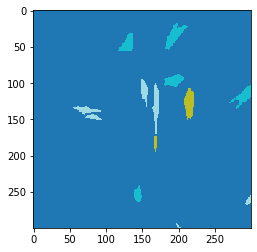

In [22]:
plt.imshow(cell_track_pred[50], cmap='tab20', interpolation='none')

In [33]:
# Write results
imageio.mimwrite('data/predictions/tracking/cell_tracking.tif', cell_track_pred)

### Compare Cell Tracking with ground truth 

We can then compare our cell tracking output with some ground truth we manually and carefully checked. 

First, we load these ground truth annotations :

In [24]:
track_gt_file = 'data/ground_truth/tracking/tracking_ground_truth_0_512_0_512.tiff'
_, track_gt_l = cv2.imreadmulti(track_gt_file, [], cv2.IMREAD_ANYDEPTH)
track_gt = np.zeros((125,300,300))
for i in range(len(track_gt_l)):
    track_gt[i] = reindex_cell_labels(track_gt_l[i][0:300,0:300])

Then we will iterate over all frames, check the overlapping cells between ground truth and cell tracking output, and check that the cells predicted at time t+1 is the same in both datasets :

In [26]:
match_list = [] ; total_list = []
match = 0 ; total = 0
for f in range(124):
    # We load predictions and ground truth at time t and t+1
    track_pred = cell_track_pred[f].copy()
    track_pred_p1 = cell_track_pred[f+1].copy()
    track_true = track_gt[f].copy()
    track_true_p1 = track_gt[f+1].copy()

    # initialize lists
    match_list.append(0) ; total_list.append(0)
    # iterate over unique labels in ground truth
    true_labels = np.unique(track_true)
    for l in true_labels:
        true_lab = true_labels[int(l)]
        # check if label is present in next frame for ground truth
        if np.sum(track_true_p1 == true_lab) > 0:
            # labels overlapping between pred and true tracks with pixel counts
            res_overlap = np.unique(track_pred[track_true == true_lab], return_counts=True)
            res_overlap = np.unique(track_pred[track_true == np.unique(track_true)[int(l)]], return_counts=True)
            overlap_labs = res_overlap[0][np.argsort(-res_overlap[1])]
            best_match = overlap_labs[0]
            for o in overlap_labs:
                # Check if matched label also overlap at t+1
                if o in np.unique(track_pred_p1[track_true_p1 == true_lab], return_counts=True)[0]:
                    match_list[f] += 1 ; match+=1
                total_list[f] += 1 ; total+=1

We can check the accuracy by comparing the number of matches divided by the total number of comparisons : 

In [28]:
overall_accuracy = match / total
overall_accuracy

0.7622093023255814

Then we "cut" it into range of 10 frames to be able to track accuracy along the movie : 

In [29]:
range_acc = []
for i in range(12):
    range_acc.append(np.array(match_list)[i*10:i*10+10] / np.array(total_list)[i*10:i*10+10])

And plot the results : 

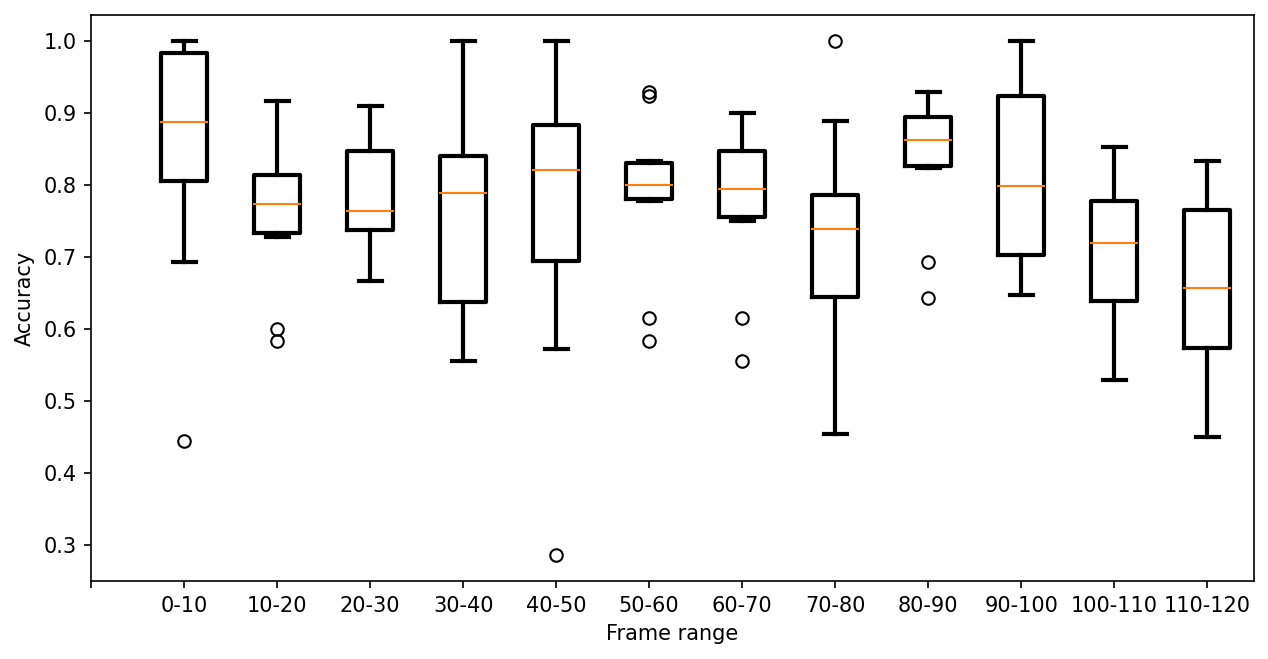

In [31]:
plt.figure(figsize=(10,5),dpi=150)
plt.boxplot(range_acc, boxprops={"linewidth":  2.0},whiskerprops={"linewidth":  2.0}, capprops={"linewidth": 2.0})
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12],
           ['','0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100','100-110','110-120'])
plt.ylabel('Accuracy') ; plt.xlabel('Frame range')
plt.show()

As we can see, prediction accuracy tend to go down at the last frames of the movie, as cells get more pacted and difficult to distinguish 